# Sentiment Analysis 

Working on prototype for deployment as Flask API


# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from numpy import array
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import re
import string

In [3]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dropout,SpatialDropout1D,Dense
from keras.utils.np_utils import to_categorical
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import load_model


# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


In [4]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# For evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [6]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas, numpy, pickle, sklearn , nltk , tensorflow,keras

Software,Version
Python,3.7.5 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.10.2
OS,Darwin 19.4.0 x86_64 i386 64bit
pandas,0.25.3
numpy,1.17.4
pickle,The 'pickle' distribution was not found and is required by the application
sklearn,0.22.2.post1
nltk,3.4.5
tensorflow,1.14.0
keras,2.2.5


# 2)- Data Loading

In [7]:
data = pd.read_csv("sentiment.tsv",sep = '\t')
data.columns = ["label","body_text"]
# Features and Labels
data['label'] = data['label'].map({'pos': 1, 'neg': 0})
data.shape

(2000, 2)

In [8]:
data.head()

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


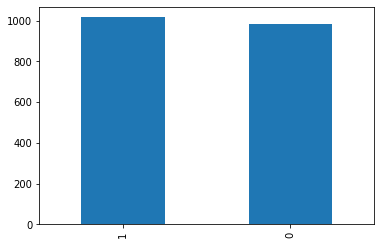

In [9]:
data.label.value_counts().plot(kind='bar')

In [10]:
data.label.value_counts(normalize=True)

1    0.508
0    0.492
Name: label, dtype: float64

1 being positive and 0 being negative sentiment

# 3)-Preprocessing/Cleaning text data

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http','https','pictwittercom']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [13]:
data['cleaned']=[text_prepare(x) for x in data['body_text']]

In [14]:
data.head()

,label,body_text,cleaned
0,1,having a vodka tonic and looking forward to go...,vodka tonic looking forward going saddle ranch...
1,1,@ddlovatofans1neg1 Could you follow me please....,ddlovatofans1neg1 could follow pleasei would r...
2,1,@jordanknight for once.................. PLEAS...,jordanknight please tell us u thinking person
3,0,Had a dream about a walk in fast food resturau...,dream walk fast food resturaunt sold ice cream...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,troybrownbbnews yes quot friendquot


### most common words

In [15]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in data['cleaned'] for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('im', 236),
 ('good', 103),
 ('today', 99),
 ('get', 98),
 ('like', 95),
 ('work', 85),
 ('dont', 84),
 ('love', 83),
 ('back', 81),
 ('got', 81)]

# 4)- Pre-Model processing

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

### 4.1)-Spliting X and y

In [17]:
X=data['cleaned']
y=data['label']

In [18]:
print(X.shape)
print(y.shape)

(2000,)
(2000,)


In [19]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(y, random_state=42)

In [20]:
print(y_train.shape)
print(y_test.shape)

(1500,)
(500,)


### 4.2)- Convert words to matrix

- We need to convert words into matrices. One way is shown through sklearn. Other way is given. We can always match the two

- Vectorize text, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,000 words.
- Set the max number of words in each complaint at 280(max size limit for text is 280 ).

#### i-I started by fitting a tokenizer on my document as in here

In [21]:
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 140
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)

In [22]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6055 unique tokens.


#### ii- I wanted to check if my data is fitted correctly so I converted into sequence

In [23]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X.values)

In [24]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1671.0,1025.0,117.0,140.0,14.0,1672.0,1673.0,1674.0,460.0,1675.0,1676.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1677.0,50.0,167.0,1678.0,55.0,15.0,1026.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1679.0,81.0,141.0,264.0,18.0,152.0,238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,461.0,399.0,297.0,168.0,1680.0,584.0,400.0,462.0,1027.0,1681.0,584.0,1682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1683.0,66.0,24.0,1684.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### iii-pad_sequence:To keep all vectors of same length, I will use pad_sequence

In [25]:
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [26]:
print('Shape of data tensor:', X_pd_sq.shape)

Shape of data tensor: (2000, 140)


In [27]:
pd.DataFrame(X_pd_sq).head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0,0,0,0,0,0,0,0,0,0,...,1025,117,140,14,1672,1673,1674,460,1675,1676
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1677,50,167,1678,55,15,1026
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1679,81,141,264,18,152,238
3,0,0,0,0,0,0,0,0,0,0,...,297,168,1680,584,400,462,1027,1681,584,1682
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1683,66,24,1684


### 4.3)- Encoding y variable

In [28]:
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [29]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(1500, 2)
(500, 2)


In [30]:
y_train_ohe[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [31]:
y_test_ohe[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [32]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

[1, 0]

In [33]:
len(unique_y_labels)

2

### 4.3)- Working for X variables

In [34]:
X_pd_sq.shape

(2000, 140)

In [35]:
X_train, X_test = train_test_split(X_pd_sq, random_state=2019)

In [36]:
X_train.shape, X_test.shape

((1500, 140), (500, 140))

# 5)- Model Building

In [37]:
embed_dim = 50
lstm_out = 32
max_fatures = 2000

In [38]:
X_pd_sq.shape[1]

140

In [39]:
len(unique_y_labels)

2

2 will be our final dense layer

In [40]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_pd_sq.shape[1]))
# X.shape[1] refers to number of columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 140, 50)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 140, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 110,690
Trainable params: 110,690
Non-trainable params: 0
_________________________________________________________________
None


### 5.1)- Train model

In [41]:
batch_size = 32
epochs = 20

In [42]:
from keras.callbacks import EarlyStopping

In [43]:

history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1350 samples, validate on 150 samples
Epoch 1/20
1350/1350 [==============================] - 5s 4ms/step - loss: 0.6935 - acc: 0.4993 - val_loss: 0.6933 - val_acc: 0.4933
Epoch 2/20
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6862 - acc: 0.6074 - val_loss: 0.6951 - val_acc: 0.5267
Epoch 3/20
1350/1350 [==============================] - 4s 3ms/step - loss: 0.6603 - acc: 0.6852 - val_loss: 0.7116 - val_acc: 0.5000
Epoch 4/20
1350/1350 [==============================] - 4s 3ms/step - loss: 0.5532 - acc: 0.7578 - val_loss: 0.8024 - val_acc: 0.4867


In [44]:
accr = model.evaluate(X_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

500/500 [==============================] - 0s 346us/step
Test set
  Loss: 0.826
  Accuracy: 0.474


# 6)-Model Evaluation

In [45]:
X_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        105,  218,    1, 1870,  611, 1871, 1872, 1873], dtype=int32)

In [46]:
# predict probabilities for test set
y_pred = model.predict(X_test)

In [47]:
y_pred[:5]

array([[0.665683  , 0.33431706],
       [0.5429998 , 0.4570002 ],
       [0.80919296, 0.19080701],
       [0.25957474, 0.7404253 ],
       [0.61479634, 0.38520363]], dtype=float32)

This is probabilities of our output. We need to convert to crisp classes.

In [48]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model.predict_classes(X_test, verbose=0)

In [49]:
yhat_classes[:5]

array([0, 0, 0, 1, 0])

In [50]:
# true values
y_test_ohe[:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [51]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [52]:
y_test_class[:5]

array([1, 0, 0, 0, 1])

In [53]:
y_pred_class[:5]

array([0, 0, 0, 1, 0])

### Classification Report

In [54]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.45      0.51      0.48       235
           1       0.50      0.44      0.47       265

    accuracy                           0.47       500
   macro avg       0.48      0.48      0.47       500
weighted avg       0.48      0.47      0.47       500



### confusion matrix

In [55]:
print(confusion_matrix(y_test_class,y_pred_class))

[[121 114]
 [149 116]]


### Accuracy and loss function

In [56]:
# for training set
loss, accuracy = model.evaluate(X_train, y_train_ohe, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.7920
Training Loss: 0.4606


In [57]:
# For test set
loss, accuracy = model.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.4740
Testing Loss:  0.8260


In [58]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

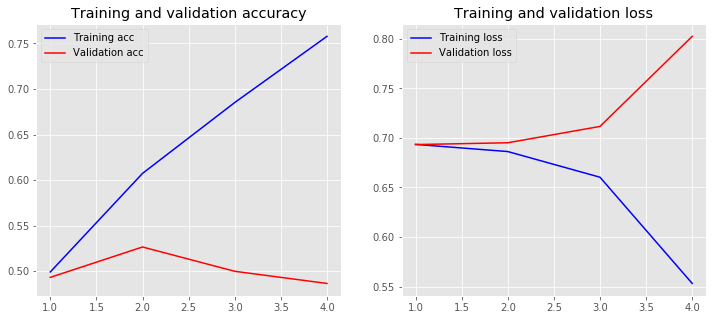

In [59]:
plot_history(history)

# 7)- Using for API

Training model with FULL data

In [60]:
X=data['cleaned']
y=data['label']

In [61]:
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 140
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)
X_token = tokenizer.texts_to_sequences(X.values)
X_pd_sq = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [62]:
X_pd_sq.shape

(2000, 140)

In [63]:
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

y_ohe=one_hot_encode_object_array(y)
y_ohe.shape

(2000, 2)

In [64]:
embed_dim = 50
lstm_out = 32
max_fatures = 2000

In [65]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_pd_sq.shape[1]))
# X.shape[1] refers to number of columns 
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 140, 50)           100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 140, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 110,690
Trainable params: 110,690
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
from keras.callbacks import EarlyStopping
batch_size = 32
epochs = 20


In [67]:
history = model.fit(X_pd_sq, y_ohe, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 6s 3ms/step - loss: 0.6905 - acc: 0.5322 - val_loss: 0.6861 - val_acc: 0.5850
Epoch 2/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.6633 - acc: 0.6928 - val_loss: 0.6539 - val_acc: 0.6050
Epoch 3/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.5263 - acc: 0.7706 - val_loss: 0.6441 - val_acc: 0.6300
Epoch 4/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.3853 - acc: 0.8322 - val_loss: 0.6880 - val_acc: 0.6050
Epoch 5/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.3101 - acc: 0.8683 - val_loss: 0.7760 - val_acc: 0.5850
Epoch 6/20
1800/1800 [==============================] - 5s 3ms/step - loss: 0.2538 - acc: 0.9011 - val_loss: 0.9182 - val_acc: 0.5750


# 8)-Serialize Model

In [68]:
#Now save the model in required directory
model.save('sentiment_analysis_model.h5')
print("Saved model to disk")

Saved model to disk


In [69]:
#Code to load the saved model
sentiment_model = load_model('sentiment_analysis_model.h5')
print("Model Loaded")

Model Loaded


# 9)-Out of sample data

In [70]:
message=["Broke a personal record of waking up&amp;leaving for work.All under posnegmins.Not sure I could do it on daily basis.Had miss salat though"]
result=message
result=pd.DataFrame(result,columns=["text"])
result

,text
0,Broke a personal record of waking up&amp;leavi...


In [71]:
x_test=result["text"]

In [72]:
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 140
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(x_test.values)
X_token = tokenizer.texts_to_sequences(x_test.values)
X_test_pad = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [73]:
X_test_pad.shape

(1, 140)

In [74]:
prediction = sentiment_model.predict(X_test_pad)
prediction

array([[0.00803952, 0.99196047]], dtype=float32)

In [75]:
prediction = sentiment_model.predict(X_test_pad)[:, 1]
prediction

array([0.99196047], dtype=float32)

In [76]:
# predict crisp classes for test set. Output will be 1-D
pred_class = sentiment_model.predict_classes(X_test_pad, verbose=0)
pred_class

array([1])

### api output

In [77]:
result["sentiment-type"] = pred_class
result["sentiment-type"] = result['sentiment-type'].map({1: "positive", 0: "negative"})
result["probability"] = prediction
json_table = result.to_json(orient='records')
json_table

'[{"text":"Broke a personal record of waking up&amp;leaving for work.All under posnegmins.Not sure I could do it on daily basis.Had miss salat though","sentiment-type":"positive","probability":0.9919604659}]'

# END of Notebook code